<a href="https://colab.research.google.com/github/RankXiaoLong/MyPython_Memory/blob/main/XiaoWuge_learning/DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Link: https://mp.weixin.qq.com/s/wG6wGAuoAsKLJ1qeLTWpJw

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# import os
# os.getcwd()


# 加载所需要的包
import warnings
warnings.filterwarnings("ignore")
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense,LeakyReLU,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve


path_d = '/content/drive/MyDrive/Mycolab'
# # 工作空间设置
os.chdir(path_d)
os.getcwd()

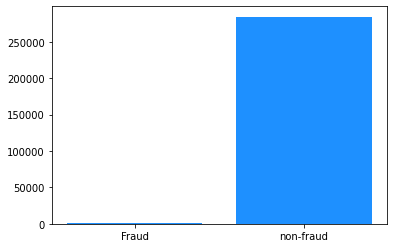

In [15]:
# 读取数据
d = pd.read_csv('/content/drive/MyDrive/Mycolab/Data/creditcard.csv')

# 查看样本比例
num_nonfraud = np.sum(d['Class'] == 0)
num_fraud = np.sum(d['Class'] == 1)
plt.bar(['Fraud', 'non-fraud'], [num_fraud, num_nonfraud], color='dodgerblue')
plt.show()

# 删除时间列，对Amount进行标准化
data = d.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data[['Amount']])
X = data.drop(['Class'],axis=1)
Y = data.Class

In [ ]:

# 设置Autoencoder的参数
input_dim = X.shape[1]
encoding_dim = 128
num_epoch = 30
batch_size = 256

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, 
         activation="tanh", 
         activity_regularizer=regularizers.l1(10e-5)
        )(input_layer)

encoder = BatchNormalization()(encoder)
encoder = LeakyReLU(alpha=0.2)(encoder)

encoder = Dense(int(encoding_dim/2), 
                activation="relu"
                )(encoder)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU(alpha=0.1)(encoder)

encoder = Dense(int(encoding_dim/4), activation="relu" )(encoder)
encoder =BatchNormalization()(encoder)



### decoder
decoder = LeakyReLU(alpha=0.1)(encoder)
decoder = Dense(int(encoding_dim/4),
         activation='tanh'
         )(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU(alpha=0.1)(decoder)


decoder = Dense(int(encoding_dim/2),
         activation='tanh'
         )(decoder)

decoder = BatchNormalization()(decoder)
decoder = LeakyReLU(alpha=0.1)(decoder)

decoder = Dense(input_dim, 
         #activation='relu'
         )(decoder)

autoencoder = Model(inputs = input_layer, 
           outputs = decoder)
autoencoder.compile(optimizer='adam', 
          loss='mean_squared_error', 
          metrics=['mae','mse'])

# 模型保存为 XiaoWuGe_model.h5，并开始训练模型
checkpointer = ModelCheckpoint(filepath="XiaoWuGe_model.h5",
                verbose=0,
                save_best_only=True)
history = autoencoder.fit(X, 
              X,
              epochs=num_epoch,
              batch_size=batch_size,
              shuffle=True,
              #validation_data=(X_test, X_test),
              verbose=1, 
              callbacks=[checkpointer]
              ).history

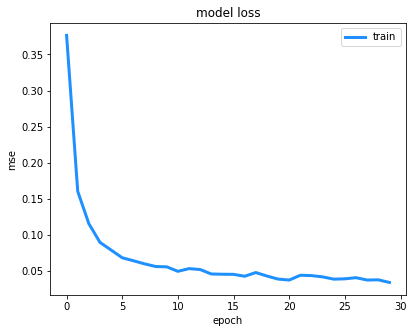

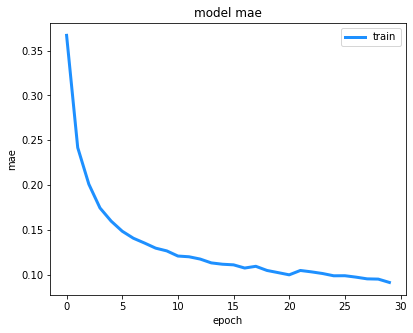

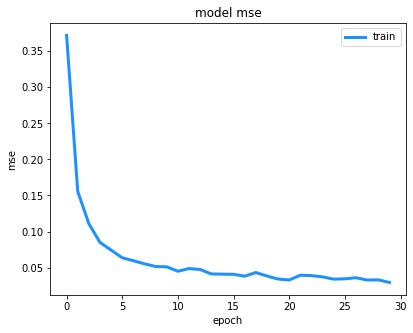

In [17]:
# 画出损失函数曲线
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(history['loss'], c='dodgerblue', lw=3)
plt.title('model loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')


# 画出损失函数曲线
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(history['mae'], c='dodgerblue', lw=3)
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')

# 画出损失函数曲线
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(history['mse'], c='dodgerblue', lw=3)
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')

In [20]:

#利用训练好的autoencoder重建测试集
pred_X = autoencoder.predict(X)
# 计算还原误差MSE和MAE
mse_X = np.mean(np.power(X-pred_X,2), axis=1)
mae_X = np.mean(np.abs(X-pred_X),axis=1)


data['mse_X'] = mse_X
data['mae_X'] = mae_X
# TopN准确率评估
n = 1000
df = data.sort_values(by='mae_X',ascending=False)
df = df.head(n)
rate = df[df['Class']==1].shape[0]/n
print('Top{}的准确率为:{}'.format(n,rate))

Top1000的准确率为:0.109


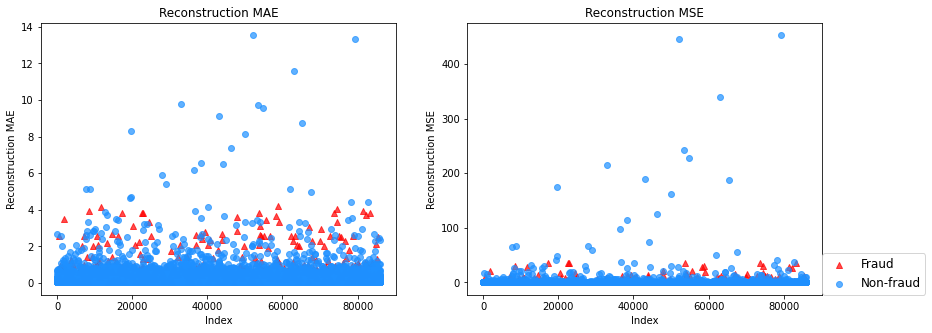

In [19]:
# 提取负样本，并且按照7:3切成训练集和测试集
mask = (data['Class'] == 0)
X_train, X_test = train_test_split(X, test_size=0.3, random_state=520)

# 提取所有正样本，作为测试集的一部分
X_fraud = X[~mask]


# 利用训练好的autoencoder重建测试集
pred_test  = autoencoder.predict(X_test)
pred_fraud = autoencoder.predict(X_fraud)


# 计算还原误差MSE和MAE
mse_test = np.mean(np.power(X_test - pred_test, 2), axis=1)
mse_fraud = np.mean(np.power(X_fraud - pred_fraud, 2), axis=1)
mae_test = np.mean(np.abs(X_test - pred_test), axis=1)
mae_fraud = np.mean(np.abs(X_fraud - pred_fraud), axis=1)
mse_df = pd.DataFrame()
mse_df['Class'] = [0] * len(mse_test) + [1] * len(mse_fraud)
mse_df['MSE'] = np.hstack([mse_test, mse_fraud])
mse_df['MAE'] = np.hstack([mae_test, mae_fraud])
mse_df = mse_df.sample(frac=1).reset_index(drop=True)


# 分别画出测试集中正样本和负样本的还原误差MAE和MSE
markers = ['o', '^']
markers = ['o', '^']
colors = ['dodgerblue', 'red']
labels = ['Non-fraud', 'Fraud']

plt.figure(figsize=(14, 5))
plt.subplot(121)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index, 
                temp['MAE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.title('Reconstruction MAE')
plt.ylabel('Reconstruction MAE')
plt.xlabel('Index')

plt.subplot(122)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index, 
                temp['MSE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.legend(loc=[1, 0], fontsize=12)
plt.title('Reconstruction MSE')
plt.ylabel('Reconstruction MSE')
plt.xlabel('Index')
plt.show()